In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('pulsar.csv', index_col=0)
df.shape

(17898, 9)

Pulsars are a rare type of Neutron star that produce radio emission detectable here on
Earth. They are of considerable scientific interest as probes of space-time, the inter-
stellar medium, and states of matter. 

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses
our line of sight, produces a detectable pattern of broadband radio emission. As pulsars
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking
for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each
rotation. Thus a 
potential signal detection known as a 'candidate', is averaged over many rotations of the
pulsar, as determined by the length of an observation. In the absence of additional info,
each candidate could potentially describe a real pulsar. However in practice almost all
detections are caused by radio frequency interference (RFI) and noise, making legitimate
signals hard to find.

Machine learning tools are now being used to automatically label pulsar candidates to
facilitate rapid analysis. Classification systems in particular are being widely adopted,
which treat the candidate data sets  as binary classification problems.
Here the legitimate pulsar examples are a minority positive class, and spurious examples
the majority negative class. At present multi-class labels are unavailable, given the
costs associated with data annotation.


In [4]:
df['target'].value_counts()

0    16259
1     1639
Name: target, dtype: int64

In the next cell, we plot a pairplot which plot each pair of features against each other.

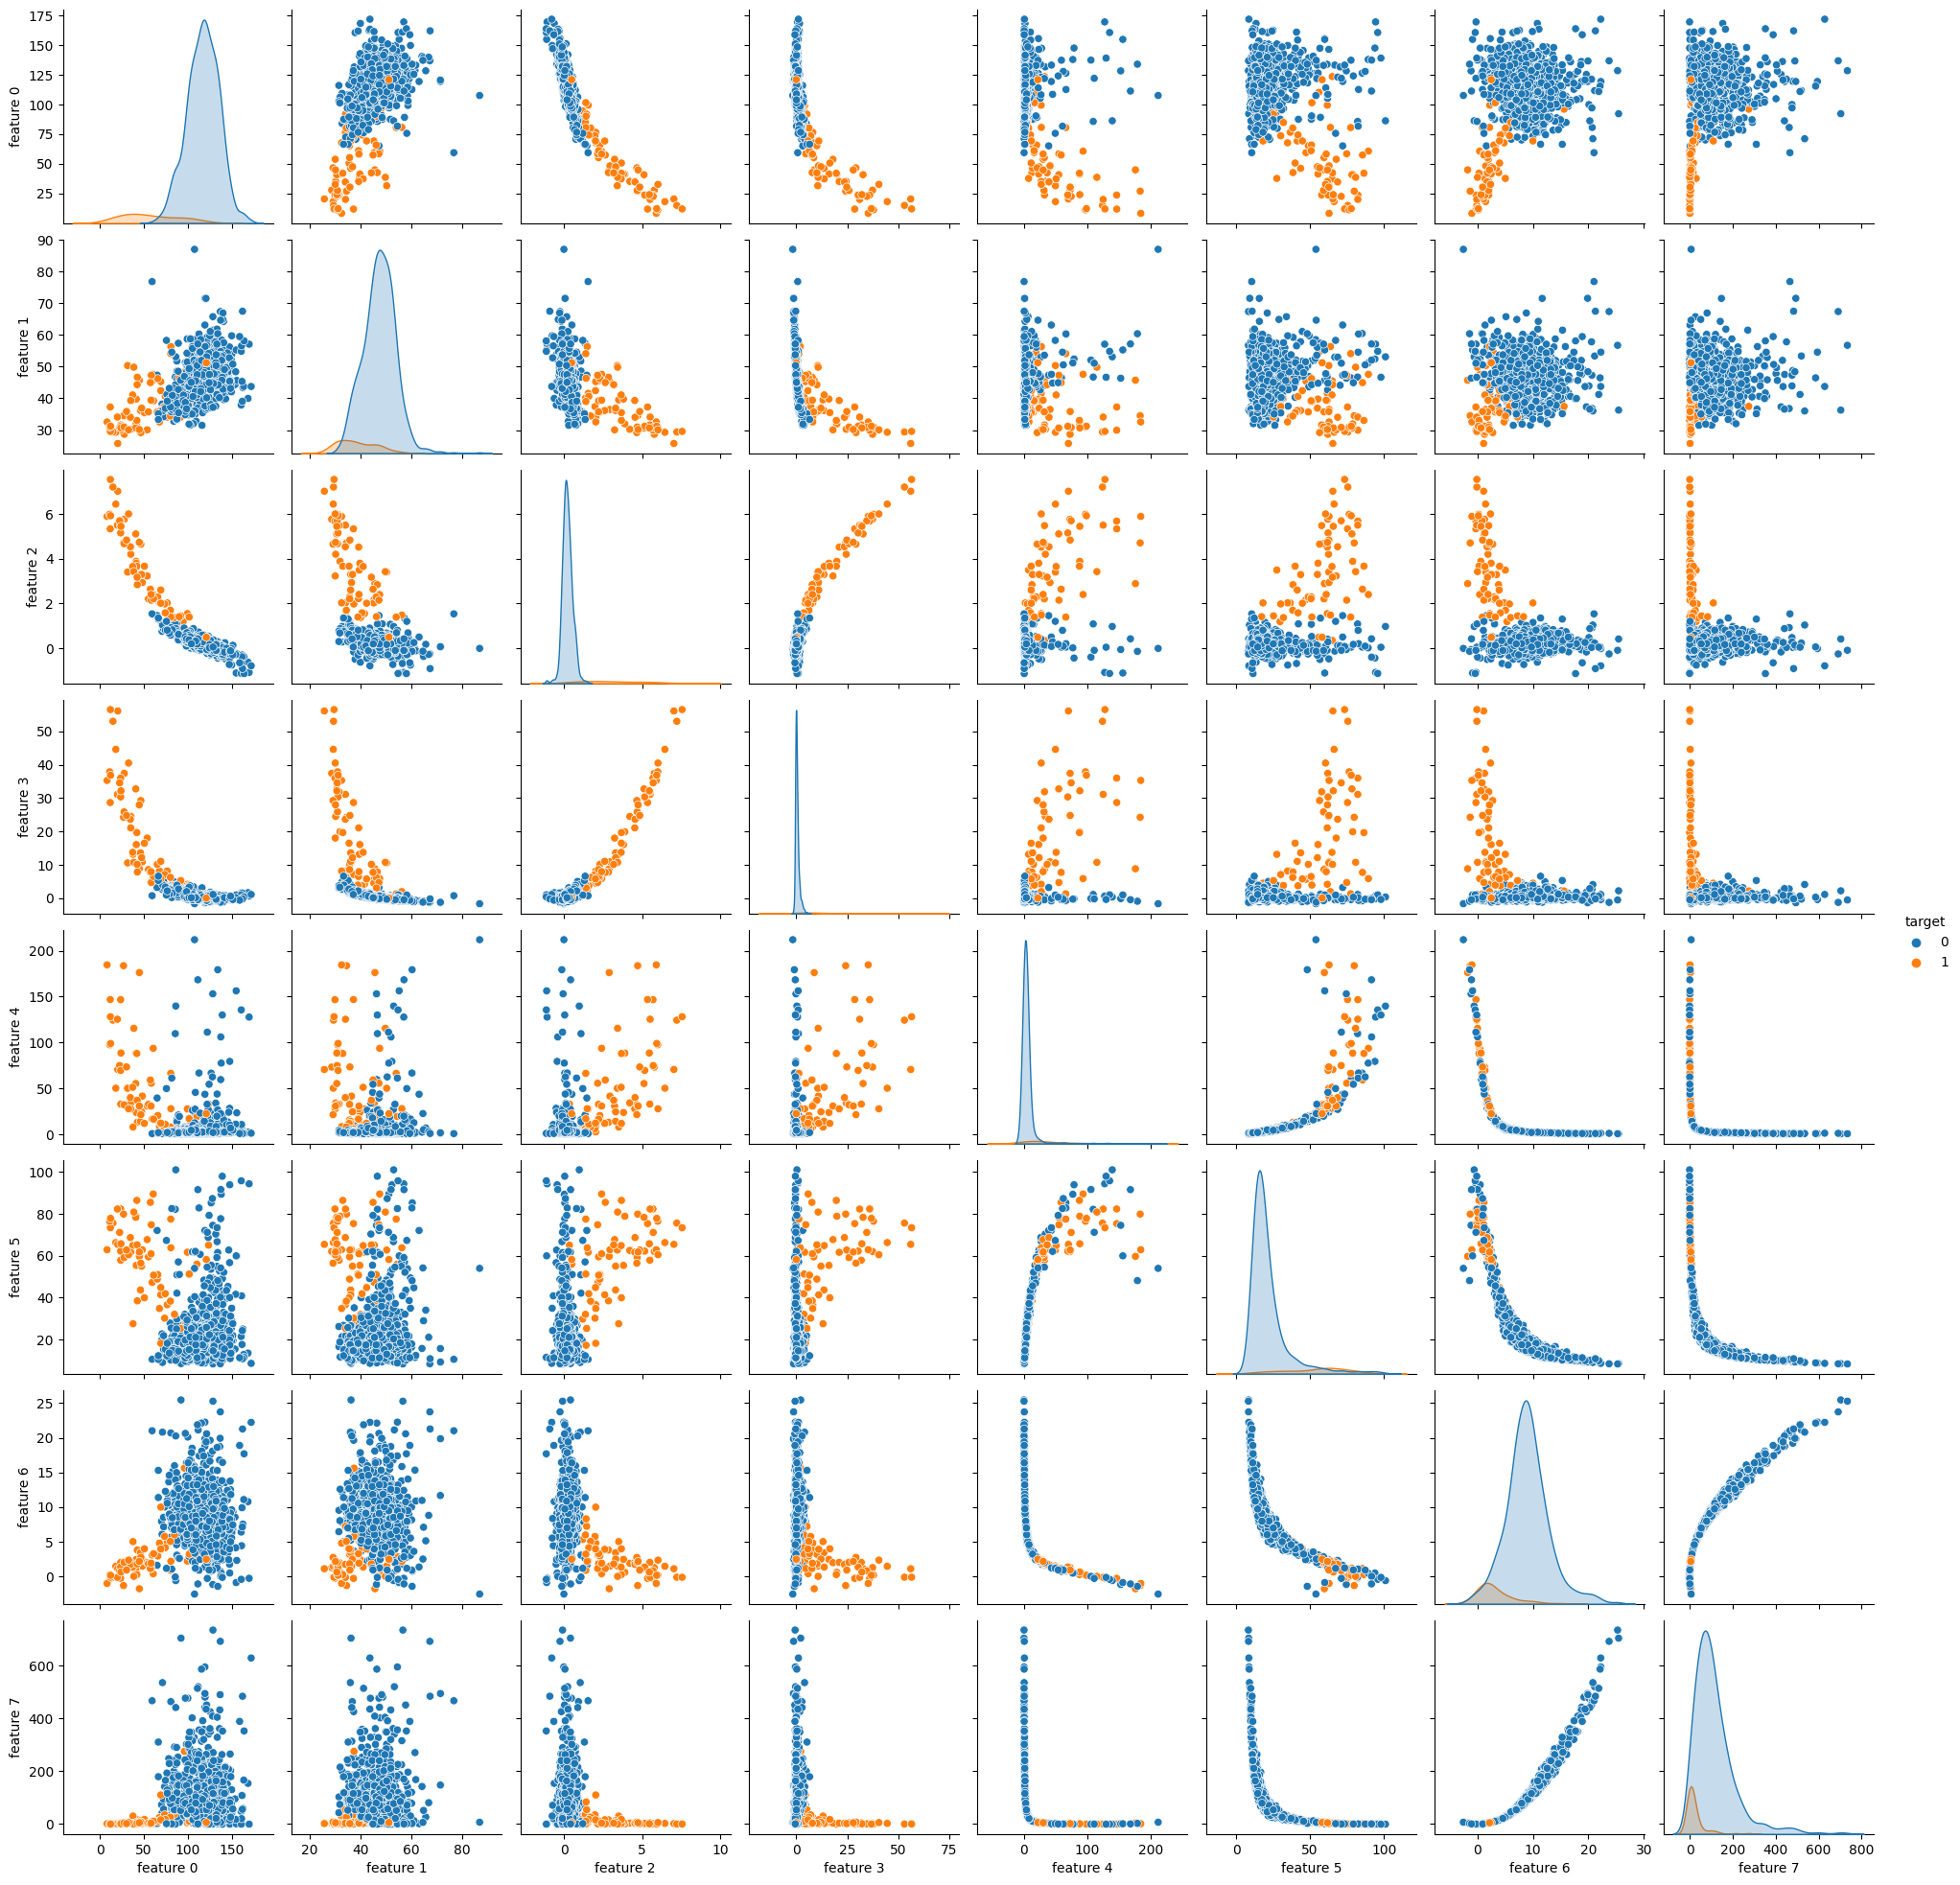

In [188]:
X = df.iloc[:1000]
sns.pairplot(X, hue="target"); # we do only on the first 1000 samples as doing it on the whole data is long

1. Some of the features need to be scaled. Execute the next cell, what are the pro and cons of Standard Scaler compared to RobustScaler?

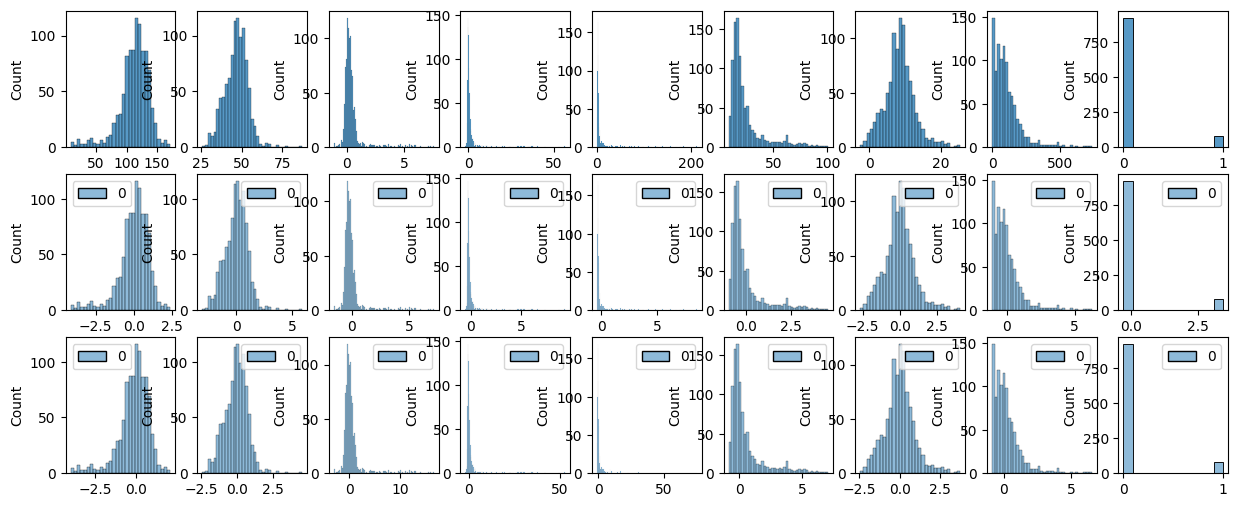

In [191]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X = np.array(df.iloc[:1000])
fig, axes = plt.subplots(3, len(X[0]), figsize=(15,6))
for f in range(len(X[0])):
    sns.histplot(X[:,f], ax = axes[0, f])
    sns.histplot(StandardScaler().fit_transform(X[:,f][:, np.newaxis]), ax = axes[1, f])  
    sns.histplot(RobustScaler().fit_transform(X[:,f][:, np.newaxis]), ax = axes[2, f])

2. What is remarkable about this dataset? In particular about its target value

In [5]:
np.mean(0 == df['target'])

0.908425522404738

3. Look at the help of sklearn.linear_mode.SGDClassifier and sklearn.model_selection.cross_val_score and use them to have a cross validation score on the dataset presented before.

In [7]:
from sklearn.linear_model import SGDClassifier

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
features = ["feature "+str(f) for f in range(8)]

clf = SGDClassifier()

print(np.mean(cross_val_score(clf, df[features], df['target'], 
                              cv= 10, scoring="accuracy")))

0.9628460392654052


4. Look at the help of sklearn.pipeline.make_pipeline and use it to have a cross validation score of SGDClassifier on a scaled version of the data.

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

clf = make_pipeline(RobustScaler(), SGDClassifier())
print(np.mean(cross_val_score(clf, df[features], df['target'], 
                              cv= 10, scoring="accuracy")))

0.9737407683828238


In [15]:
clf

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('sgdclassifier', SGDClassifier())])

In [14]:
?make_pipeline

Signature: make_pipeline(*steps, memory=None, verbose=False)
Docstring:
Construct a :class:`Pipeline` from the given estimators.

This is a shorthand for the :class:`Pipeline` constructor; it does not
require, and does not permit, naming the estimators. Instead, their names
will be set to the lowercase of their types automatically.

Parameters
----------
*steps : list of Estimator objects
    List of the scikit-learn estimators that are chained together.

memory : str or object with the joblib.Memory interface, default=None
    Used to cache the fitted transformers of the pipeline. By default,
    no caching is performed. If a string is given, it is the path to
    the caching directory. Enabling caching triggers a clone of
    the transformers before fitting. Therefore, the transformer
    instance given to the pipeline cannot be inspected
    directly. Use the attribute ``named_steps`` or ``steps`` to
    inspect estimators within the pipeline. Caching the
    transformers is advanta

5. Use sklearn.metrics.confusion_matrix to get the confusion matrix of the prediction you made just now. What do you notice?

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# compare comparable things: split so that 1/5 is used as test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.1)
clf = make_pipeline(RobustScaler(), SGDClassifier(loss="log_loss"))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[1581,   36],
       [  24,  149]])

6. Comment on the next cell.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
for d in range(1, 4):
    print("degree "+str(d))
    clf = make_pipeline(PolynomialFeatures(degree = d), RobustScaler(), 
                        SGDClassifier(max_iter=5000))
    print("Accuracy", np.mean(cross_val_score(clf, df[features], df['target'], cv= 10, scoring="accuracy")))
    print("AUC", np.mean(cross_val_score(clf, df[features], df['target'], cv= 10, scoring="roc_auc")))

degree 1
Accuracy 0.9772042057140004
AUC 0.9461693188814853
degree 2
Accuracy 0.9756957633708166
AUC 0.9529282280949284
degree 3
Accuracy 0.96591704113593
AUC 0.8514734100984238


7. Compute the Accuracy and AUC of SGDClassifier for several values of its loss parameter. Is there a loss that is better than the others? 
Remark: setting the parameter `n_iter_no_change=100` may help to have more stable results for some losses

In [24]:
for loss in ["log_loss",'hinge','modified_huber', 'perceptron']:
    print("\nloss "+loss)
    clf = make_pipeline(RobustScaler(), SGDClassifier(loss=loss, n_iter_no_change=100))
    print("Accuracy", np.mean(cross_val_score(clf, df[features], df['target'], cv = 10, scoring="accuracy")))
    print("AUC", np.mean(cross_val_score(clf, df[features], df['target'], cv = 10, scoring="roc_auc")))


loss log_loss
Accuracy 0.9780419759486121
AUC 0.9752471862005077

loss hinge
Accuracy 0.97848909068766
AUC 0.9636211153211105

loss modified_huber


/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy 0.9682092302119407


/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-p

AUC 0.9586007140411187

loss perceptron
Accuracy 0.9668681982693743
AUC 0.9482998660845505


8. Use sklearn.metrics.ConfusionMatrixDisplay and sklearn.metrics.RocCurveDisplay to plot some nice representations of both confusion matrices and ROC curves.

/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


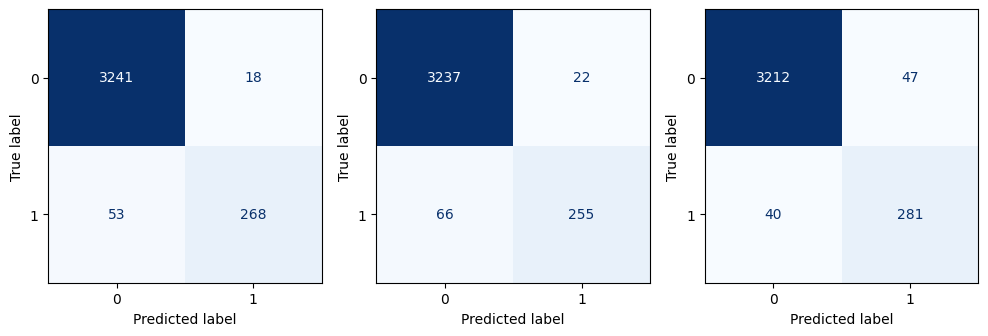

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.2, random_state=42)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes = axes.ravel()
for d in range(1, 4):
    clf = make_pipeline(PolynomialFeatures(degree = d), RobustScaler(), SGDClassifier(loss="log_loss", 
                                                                                      n_iter_no_change=100))
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    C = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=C)
    disp.plot(ax = axes[d-1], cmap=plt.cm.Blues,colorbar=False)

/home/frost/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


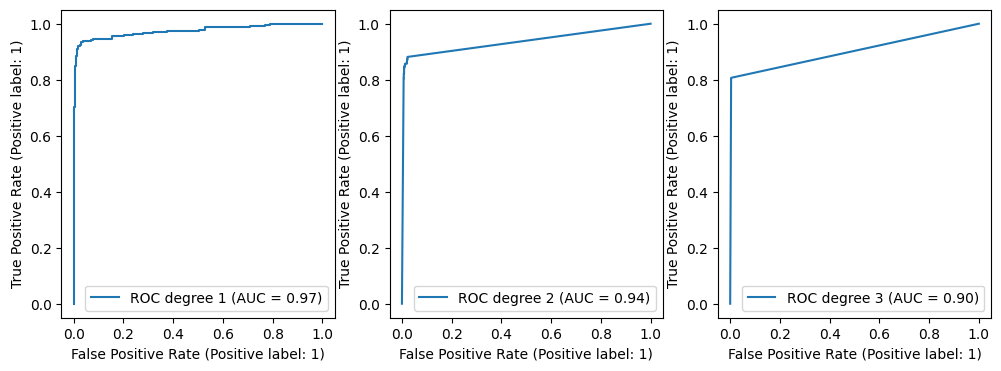

In [26]:
from sklearn.metrics import RocCurveDisplay

X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.2, random_state=42)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes = axes.ravel()
for d in range(1, 4):
    clf = make_pipeline(PolynomialFeatures(degree = d), 
                        RobustScaler(), 
                        SGDClassifier(loss="log_loss", n_iter_no_change=100))
    clf.fit(X_train, y_train)
    prediction = clf.predict_proba(X_test)
    viz = RocCurveDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        name=f"ROC degree {d}",
        ax=axes[d-1],
    )